In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [201]:
import os
this_directory = os.path.realpath(".")
home_directory = os.path.split(this_directory)[0]
data_directory = os.path.join(home_directory, "data")
images_directory = os.path.join(home_directory, "images")

In [228]:
features = pd.read_pickle("{}/qozs_features.pkl".format(data_directory))
features.reset_index(inplace=True, drop=True)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 16 columns):
population_total           8685 non-null float64
age_median                 8682 non-null float64
p_never_married            8685 non-null float64
p_white                    8685 non-null float64
p_black                    8685 non-null float64
p_poverty                  8685 non-null float64
household_income_median    8657 non-null float64
home_value_median          8382 non-null float64
structure_year_median      8661 non-null float64
p_outofcountyflux          7822 non-null float64
p_pop_renting              8679 non-null float64
p_units_vacant             8679 non-null float64
p_mobilehomes              8679 non-null float64
p_multiple_unit_strucs     8679 non-null float64
state                      8685 non-null object
tract                      8685 non-null object
dtypes: float64(14), object(2)
memory usage: 1.1+ MB


# Can skip this part if you have already generated state_info.pkl

In [209]:
state_numbers = np.unique(features['state'])
state_info = pd.DataFrame(state_numbers, columns=['fips'])

In [210]:
from us import states
## add name
fips_to_name = states.mapping('fips', 'name')
state_info['name'] = state_info['fips'].apply(lambda row : fips_to_name[row])
## add abbr
fips_to_abbr = states.mapping('fips', 'abbr')
state_info['abbr'] = state_info['fips'].apply(lambda row : fips_to_abbr[row])

In [211]:
## add number of OZs
state_info['n_ozs'] = features.groupby('state').agg({'state':'count'})['state'].values

In [212]:
## add number of tracts
census_key = "be526a50bd1d95edbf21709b4e5c72a3c0436af0"
from census import Census
c = Census(key=census_key, year=2015)
len(c.acs5.get('B01003_001E', {'for' : f'tract:*', 'in' : f'state:01 county:*'}))

1181

In [213]:
n_tracts = []
for state in state_info.fips.values:
    n = len(c.acs5.get('B01003_001E', {'for' : 'tract:*', 'in' : f'state:{state} county:*'}))
    n_tracts.append(n)
    #print(f'{state_info[state_info.fips == state].name.values[0]} has {n} census tracts.')
state_info['n_tracts'] = n_tracts

In [214]:
state_info.to_pickle(f"{data_directory}/states.pkl")

# Start here!

In [229]:
state_info = pd.read_pickle(f"{data_directory}/states.pkl")

Top 10 States : ['PR' 'WY' 'MS' 'AK' 'DC' 'VT' 'AL' 'GA' 'LA' 'KY']


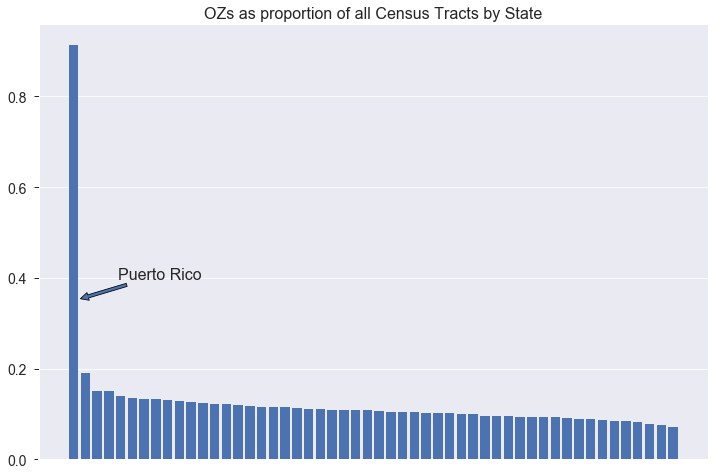

In [230]:
## OZs as proportion of all census tracts in a state
sns.set_context('paper')
fig, ax = plt.subplots(figsize=(12,8))

p_ozs = state_info['n_ozs'].values / state_info['n_tracts'].values
sort_i = np.argsort(p_ozs)[::-1]
x = np.arange(len(p_ozs))

ax.bar(x, p_ozs[sort_i], label = f"Top 10 States : \n {state_info.abbr.values[sort_i][:10]}")
ax.set_title("OZs as proportion of all Census Tracts by State", fontsize=16)
ax.set_xticks([])
ax.set_yticklabels(np.round(ax.get_yticks(), 2), fontsize=14)
ax.annotate('Puerto Rico', (40, 160), xytext = (80, 180),\
            xycoords='axes points', arrowprops={'arrowstyle':'simple'}, fontsize=16)
#fig.legend(loc=(10,10))

plt.savefig(f"{images_directory}/ozs_by_states.png", dpi=120)
print(f"Top 10 States : {state_info.abbr.values[sort_i][:10]}")

In [231]:
# Tracts by state w/o Puerto Rico
# fig, ax = plt.subplots(figsize=(12,8))

# ax.bar(x[1:], p_ozs[sort_i][1:])
# ax.set_title("Without Puerto Rico", fontsize=16)
# ax.set_xticks([])
# ax.set_yticklabels(np.round(ax.get_yticks(), 2), fontsize=14)

# plt.savefig(f"{images_directory}/ozs_by_state_wo_PR.png", dpi=120)

In [232]:
plotter_features = features.drop(columns=['tract', 'state'])
plotter_features.columns[1]

'age_median'

In [233]:
PR = features[features['state'] == '72']
all_others = features[features['state'] != '72']

In [234]:
## make sure the big negative numbers were replaced with nans
features.iloc[6945]

population_total                    15
age_median                         NaN
p_never_married                      1
p_white                              1
p_black                              0
p_poverty                            1
household_income_median            NaN
home_value_median                  NaN
structure_year_median              NaN
p_outofcountyflux                  NaN
p_pop_renting                        1
p_units_vacant                   0.632
p_mobilehomes                        0
p_multiple_unit_strucs               0
state                               72
tract                      72127980000
Name: 6945, dtype: object

<function matplotlib.pyplot.show(*args, **kw)>

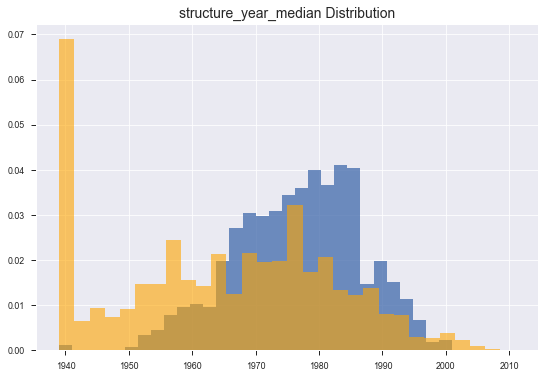

In [252]:
fig, ax = plt.subplots(figsize=(9, 6))

f = plotter_features.columns[8]
b = 30

y_PR = PR[f].dropna().values
y_others = all_others[f].dropna().values
ax.hist(y_PR, bins=b, density=True, alpha=0.8)
ax.hist(y_others, bins=b, density=True, alpha=0.6, color='orange')
ax.set_title(f"{f} Distribution", fontsize=14)
plt.show

# plt.savefig(f"{images_directory}/{feature}_dist.png", dpi=120)
# features to go look back at : 
## structure year median - looks like PR has many more homes built 1940 (or before)
## multiple unit strucs – in general PR has more units per structure, 
## although maybe my definition of this feature isn't good